# Performance Analysis

Questions:
- Is there more information in clicks than in solving times?

In [2]:
# Settings and imports.
%matplotlib inline
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import parallel_coordinates
import seaborn as sns
import data

sns.set()
sns.set_context('poster')
sns.set_style('whitegrid')
pd.options.display.float_format = '{:.2f}'.format

# Preparing Data

In [3]:
ts = data.load('robomission-2018-03-10/task_sessions.csv')
# Only consider sessions with an interaction.
ts = ts[ts.time_spent > 0]
# Set maximum spent time to 1h.
ts.time_spent = ts.time_spent.clip_upper(60 * 60)
ts = ts.assign(date=ts.end.str[:10])
ts.head(2)

,student,task,solved,start,end,time_spent,date
id,,,,,,,
39,917,26,False,2017-11-13T10:58:19.666306Z,2017-11-13T10:59:21.969801Z,62,2017-11-13
28,584,41,True,2017-11-12T08:57:39.741460Z,2017-11-12T08:58:43.087657Z,63,2017-11-12


In [4]:
tasks = data.load('robomission-2018-03-10/tasks.csv')
levels = data.load('robomission-2018-03-10/levels.csv')

In [5]:
snapshots = data.load('robomission-2018-03-10/program_snapshots.csv')
edits = snapshots[snapshots.granularity == 'edit']
executions = snapshots[snapshots.granularity == 'execution']
snapshots.head(2)

,task_session,time,program,granularity,order,correct,time_from_start,time_delta
id,,,,,,,,
1,1,2017-11-10T10:25:16.906946Z,f,edit,1,NaN,8,8
2,1,2017-11-10T10:25:17.965605Z,ff,edit,2,NaN,9,1


# All Task Sessions

In [6]:
ts['edits'] = edits.groupby('task_session').program.count() + 1
ts.edits = ts.edits.fillna(1)
ts.head()

,student,task,solved,start,end,time_spent,date,edits
id,,,,,,,,
39,917,26,False,2017-11-13T10:58:19.666306Z,2017-11-13T10:59:21.969801Z,62,2017-11-13,1.00
28,584,41,True,2017-11-12T08:57:39.741460Z,2017-11-12T08:58:43.087657Z,63,2017-11-12,7.00
13,29,8,True,2017-11-10T12:24:07.602156Z,2017-11-10T12:24:24.986604Z,17,2017-11-10,6.00
1,5,25,True,2017-11-10T10:25:08.451949Z,2017-11-10T10:25:22.612931Z,14,2017-11-10,4.00
2,29,25,True,2017-11-10T12:19:38.296521Z,2017-11-10T12:19:50.945672Z,12,2017-11-10,4.00


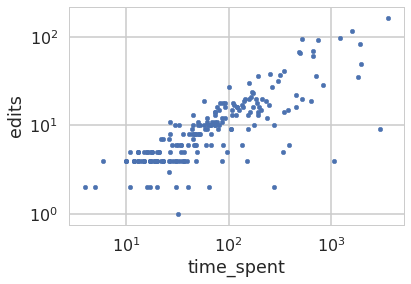

In [7]:
ts.sample(n=200).plot.scatter(
    x='time_spent', y='edits',
    logx=True, logy=True)

The correlation between the log-time and log-edits is quite high:

In [8]:
ts['log_time'] = ts.time_spent.apply(np.log)
ts['log_edits'] = ts.edits.apply(np.log)
ts.log_time.corr(ts.log_edits)

0.73190121566360433

# Within Task

Correlations within a task:

In [9]:
corr = ts[['task', 'log_time']].groupby('task')\
    .corrwith(ts.log_edits).log_time
corr.sort_values(ascending=False)

task
74    0.92
65    0.87
32    0.82
79    0.80
19    0.79
57    0.78
42    0.77
43    0.76
6     0.76
63    0.76
28    0.76
73    0.76
20    0.76
18    0.75
62    0.75
34    0.75
76    0.75
80    0.74
16    0.73
68    0.72
21    0.72
85    0.72
55    0.71
41    0.71
22    0.71
17    0.71
77    0.70
81    0.70
64    0.69
40    0.68
      ... 
82    0.57
27    0.56
31    0.54
66    0.54
30    0.54
13    0.53
69    0.53
53    0.52
48    0.50
52    0.50
12    0.49
72    0.48
58    0.48
54    0.47
71    0.47
84    0.46
10    0.46
9     0.43
86    0.42
33    0.39
75    0.39
2     0.38
39    0.35
44    0.34
49    0.32
26    0.31
36    0.30
7     0.19
51    0.10
25   -0.02
Name: log_time, Length: 86, dtype: float64

In [25]:
corr.describe()

count   86.00
mean     0.60
std      0.17
min     -0.02
25%      0.50
50%      0.64
75%      0.72
max      0.92
Name: log_time, dtype: float64

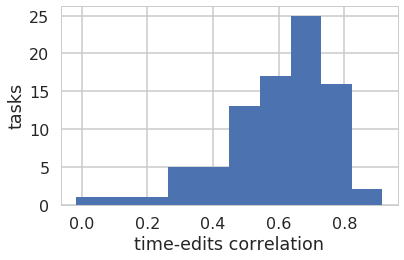

In [26]:
ax = corr.plot.hist()
ax.set_xlabel('time-edits correlation')
ax.set_ylabel('tasks')
plt.tight_layout()
plt.savefig('../img/time-edits-corr.pdf')

Example of task with high correlation:

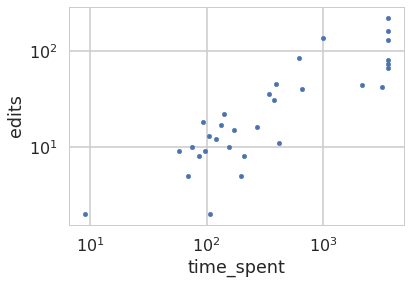

In [12]:
ts[ts.task == 65].plot.scatter(
    x='time_spent', y='edits',
    logx=True, logy=True)

Task with the lowest correlation (~ 0):

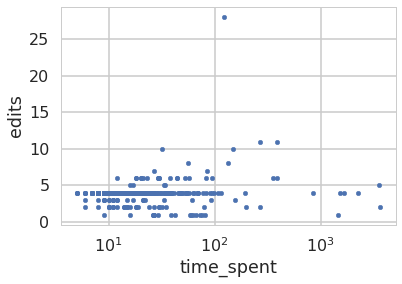

In [13]:
ts[ts.task == 25].plot.scatter(
    x='time_spent', y='edits',
    logx=True)

Q: How the correlation relates to the (1) amount of collected data, (2) difficulty of the task?

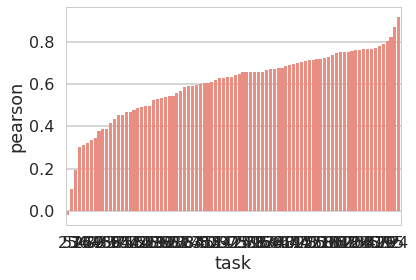

In [14]:
gts = ts.groupby('task')
df = pd.DataFrame(OrderedDict(
    log_time=gts.log_time.mean(),
    n_attempts=gts.log_time.count()
))
#df = tasks.merge(metrics, left_index=True, right_index=True)
#df = df[['log_time', 'n_attmpt']]
df['pearson'] = corr
df = df.reset_index('task').sort_values('pearson')
df.head()
sns.barplot(x='task', y='pearson', data=df, color="salmon", order=df.task)

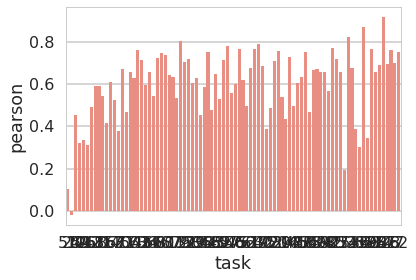

In [15]:
# Sorted by difficulty
df = df.sort_values('log_time')
sns.barplot(x='task', y='pearson', data=df, color="salmon", order=df.task)

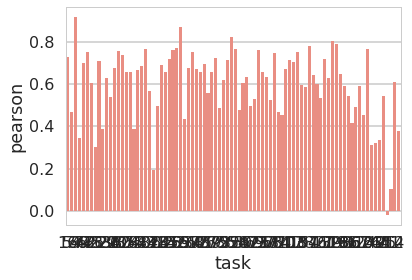

In [16]:
# Sorted by number of collected attempts
df = df.sort_values('n_attempts')
sns.barplot(x='task', y='pearson', data=df, color="salmon", order=df.task)

# Tasks Aggregation

Visualization of mean log-times and log-edits for all tasks, colored by the current level.

In [17]:
gts = ts.groupby('task')
df = pd.DataFrame(OrderedDict(
    log_time=gts.log_time.median(),
    log_edits=gts.log_edits.median(),
))
df = df.join(tasks)
df = df.merge(
    levels, left_on='level', right_on='name',
    suffixes=('', '_value'))
df = df.sort_values('level_value')
df = df[['name', 'log_time', 'log_edits', 'level']]
df.head()

,name,log_time,log_edits,level
20,plus,3.09,1.61,moves
15,diamond-on-right,3.40,1.61,moves
14,turning-right-and-left,3.04,1.39,moves
13,three-steps-forward,2.64,1.39,moves
12,beware-of-asteroid,3.47,1.39,moves


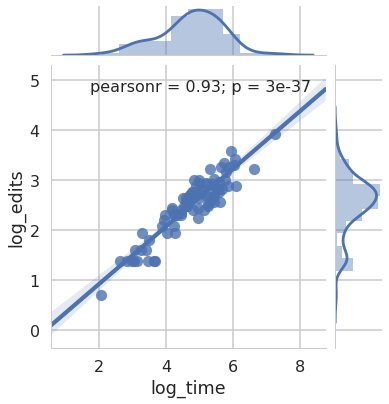

In [18]:
sns.jointplot(x='log_time', y='log_edits', data=df, kind='reg')

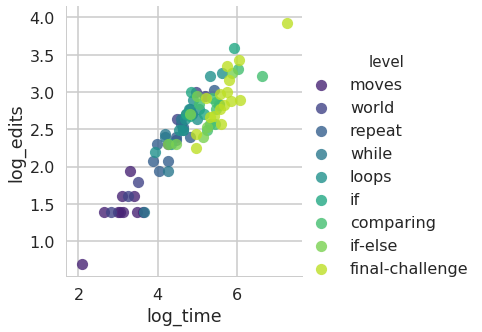

In [19]:
sns.lmplot(x='log_time', y='log_edits', hue='level',
           palette='viridis', data=df, fit_reg=False)

The same thing, just split by levels. Visually, the levels look quite homogenous, with the exception of the 2nd level (world) which clearly contains two separate clusters.

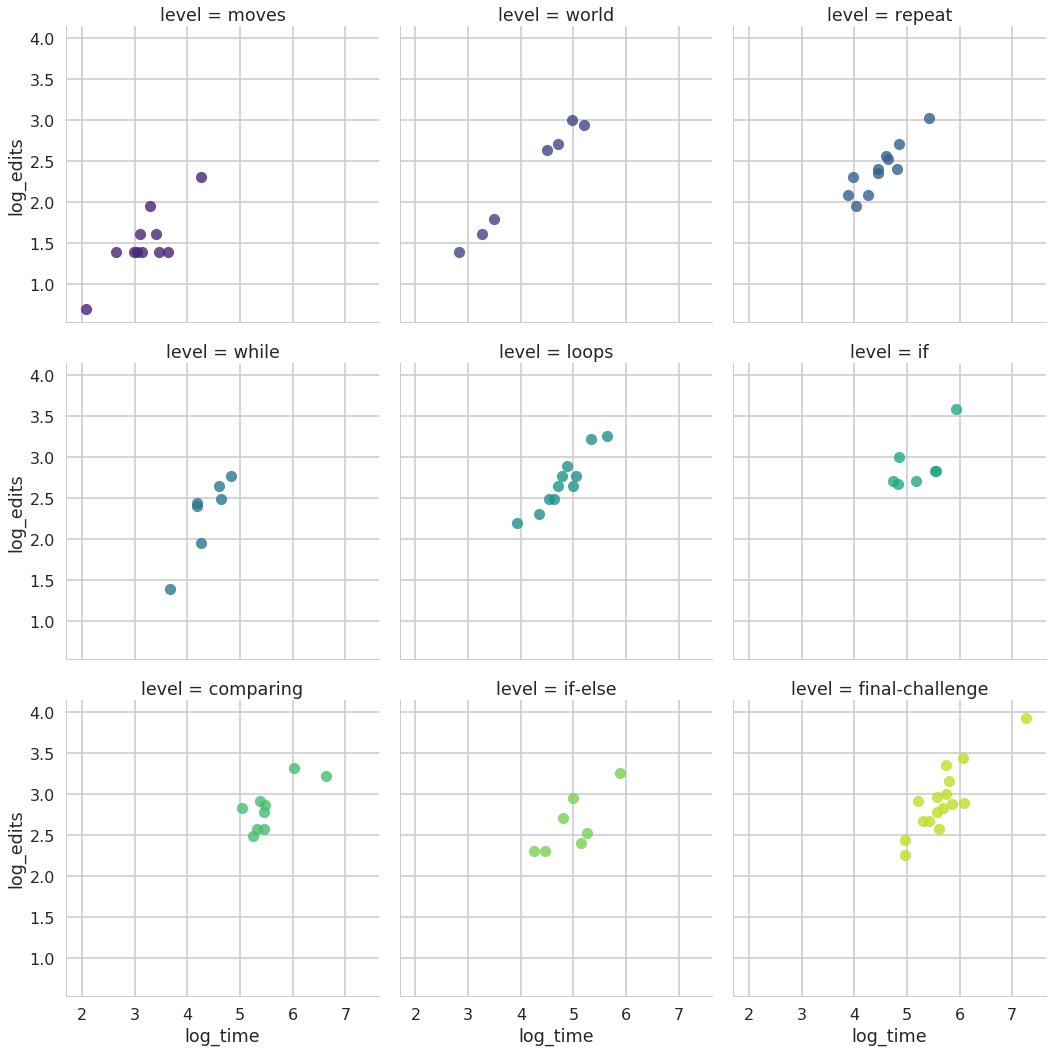

In [21]:
sns.lmplot(x='log_time', y='log_edits', hue='level',
           col='level', col_wrap=3,
           palette='viridis', data=df, fit_reg=False)
plt.tight_layout()
plt.savefig('../img/difficulties-tasks-levels.pdf')